In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import sys

sys.path.append('../')
from carpet_reconstruction import GetCarpetSignal, VEM, VEM2rp, find_smoothest_max, neighbors, fit_coeffs, get_xy_fits, num_sort, get_annealing_xy

from matplotlib.backends.backend_pdf import PdfPages
from skimage.feature import peak_local_max

In [2]:
plt.rcParams['figure.dpi'] = 400

In [3]:
filename = '../Geant4Model/build/Output/output_test.root'
file = uproot.open(filename)

names = np.array(file.keys())
times = names[:len(names) // 3]
cover_hists = names[len(names) // 3::2]

In [4]:
digit_pattern = "-?\d+\.?\d*"

In [5]:
cover_signals = np.zeros((len(cover_hists), 20, 20))

for i, hist in enumerate(cover_hists):
    cov_hist = np.copy(np.flip(file[hist].values().T, 0))
    
    cover_signals[i] = GetCarpetSignal(cov_hist)

# МНК

In [6]:
pdf = PdfPages("100_Showers_intersection_reconstruction.pdf")

for signal in cover_signals:

    sinal_copy = np.copy(signal)

    sig = VEM2rp(sinal_copy)

    plt.imshow(signal, cmap='turbo')

    row0, col0 = get_xy_fits(sig)

    plt.plot(col0, row0, 'mo')

    pdf.savefig()
    plt.close('all')

pdf.close()

# Поиск локального максимума

[8 0]


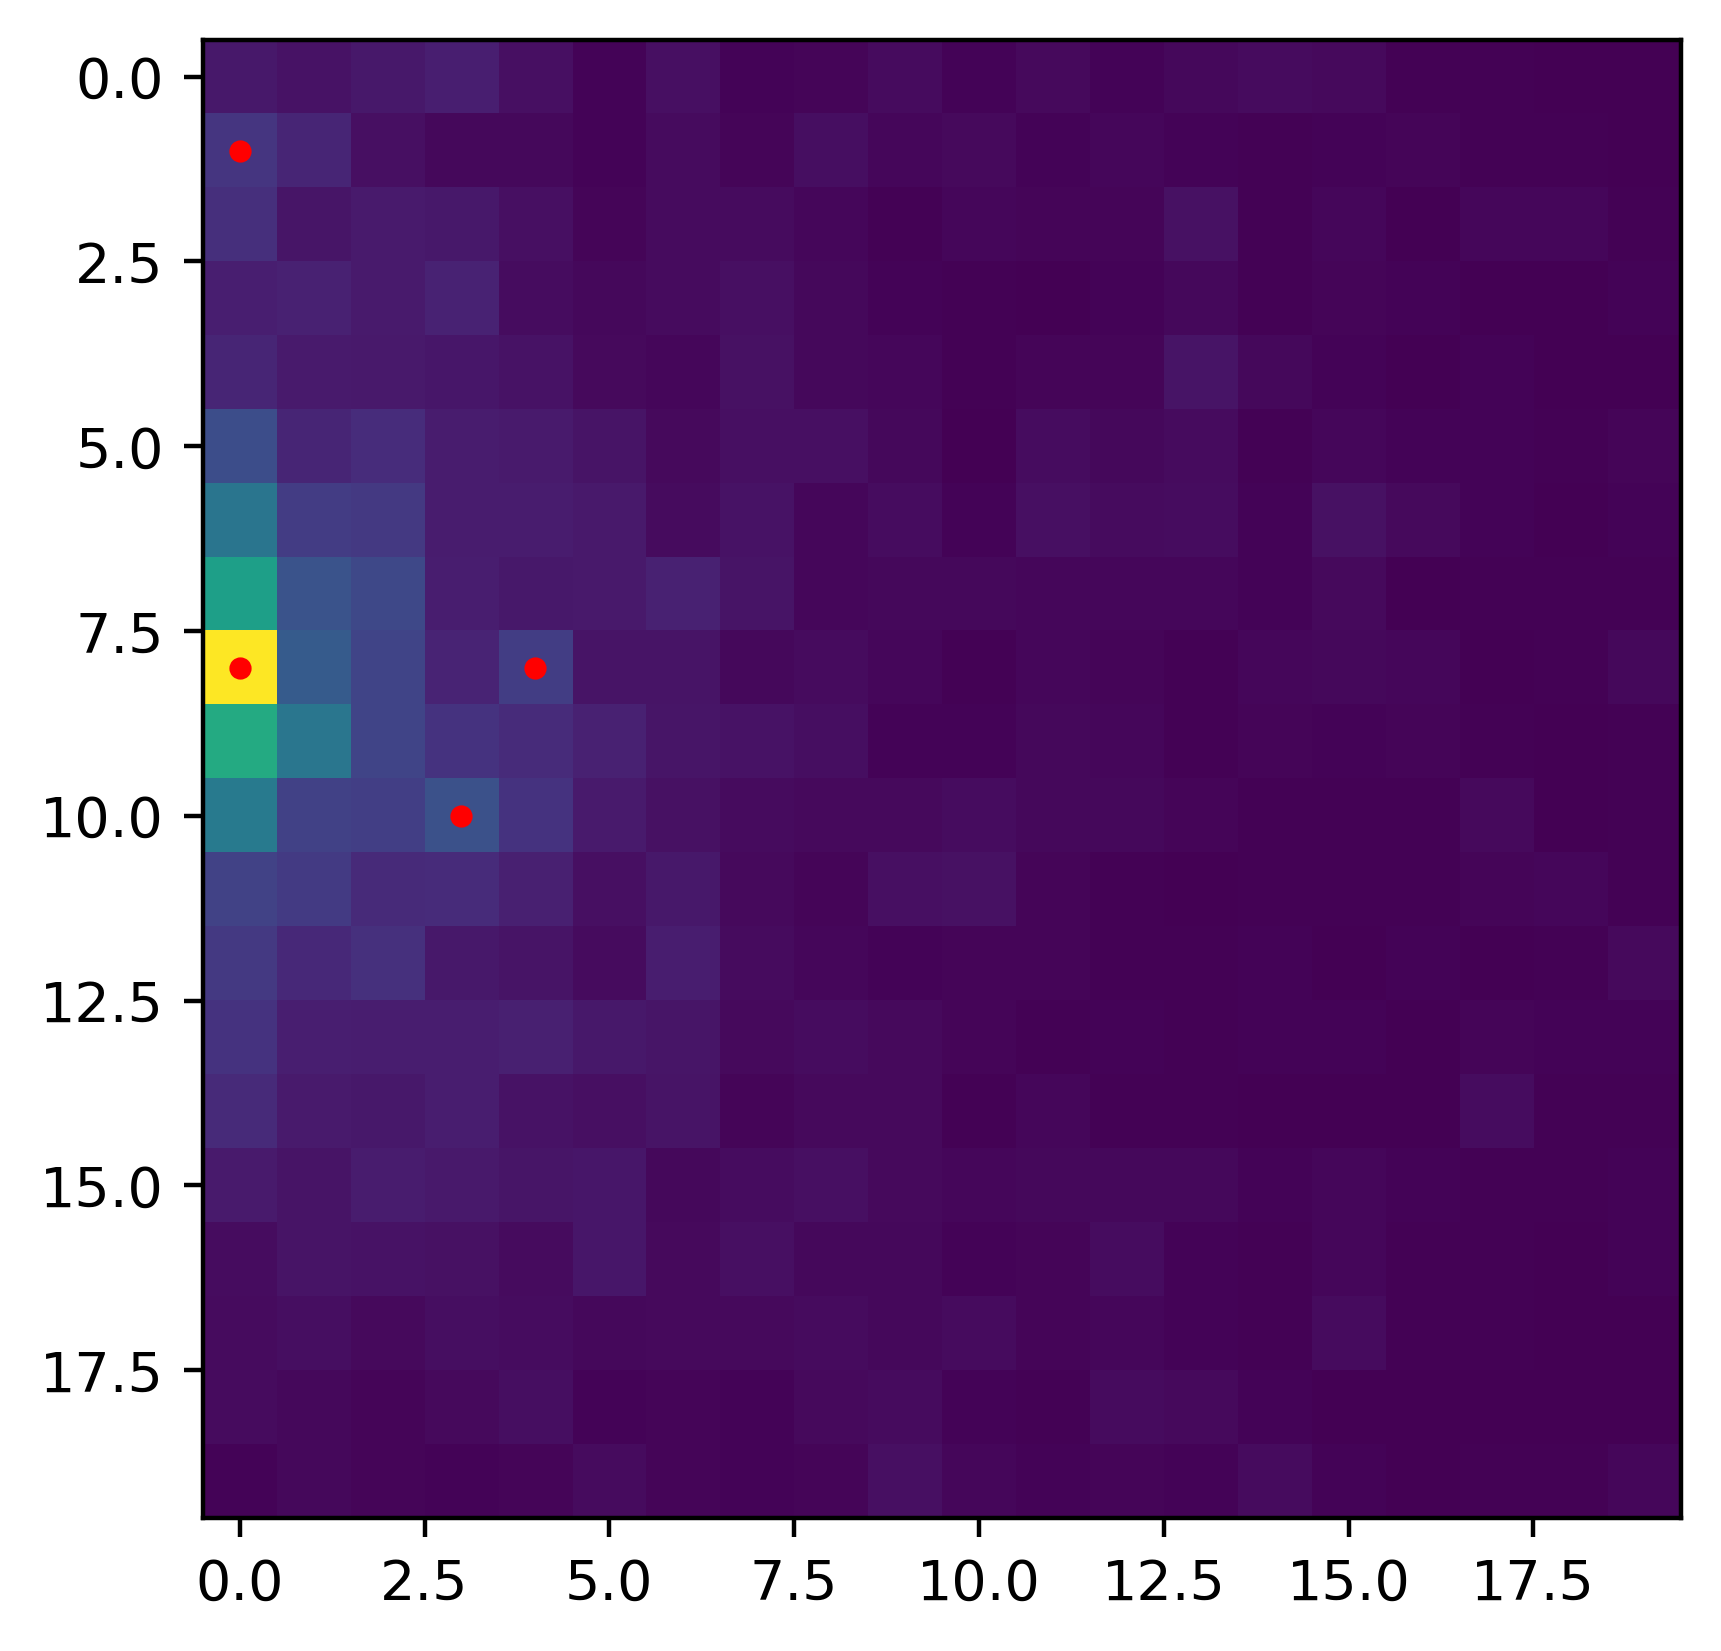

In [7]:
coordinates = peak_local_max(cover_signals[0], exclude_border=False, threshold_rel=0.1)

print(find_smoothest_max(cover_signals[0], coordinates))

plt.imshow(cover_signals[0])
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

plt.grid(False)

In [8]:
pdf = PdfPages("100_Showers_reconstruction_local_max_with_error.pdf")

# Данный алгоритм осуществляет поиск локального максимума в откликах центрального "Ковра"

for signal in cover_signals:

    sinal_copy = np.copy(signal)

    ind_x = np.random.randint(0, 20)
    ind_y = np.random.randint(0, 20)

    max_sig = np.max(sinal_copy)

    if max_sig < 100:
        sinal_copy[ind_x][ind_y] += 5*max_sig
    else:
        sinal_copy[ind_x][ind_y] += 500

    sig = VEM(sinal_copy)
    
    plt.imshow(sig, cmap = 'turbo')
    plt.grid(False)
    
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    
    for i in range(sinal_copy.shape[0]):
        for j in range(sinal_copy.shape[1]):
            #plt.text(j, i, round(sig[i, j]), ha="center", va="center", color="w", fontsize=5)
            if ((i == ind_x) & (j == ind_y)):
                plt.text(j, i, round(sig[i, j]), ha="center", va="center", color="r", fontsize=10)
            else:
                plt.text(j, i, round(sig[i, j]), ha="center", va="center", color="w", fontsize=5)
    
    coordinates = peak_local_max(sig, exclude_border=False, threshold_rel=0.1)
    xy = find_smoothest_max(sig, coordinates)
    
    plt.axvline(x=xy[1], linewidth=1, color='r')
    plt.axhline(y=xy[0], linewidth=1, color='r')

    pdf.savefig()
    plt.close()

pdf.close()

# Signal upscale

In [9]:
pdf = PdfPages("100_Showers_reconsctruction_total_upscale.pdf")

# Данный алгоритм осуществляет поиск локального максимума в откликах центрального "Ковра". Предварительно сигнал масштабируется кубической интерполяцией

for signal in cover_signals:

    sinal_copy = np.copy(signal)

    sig = VEM(sinal_copy)

    fig, axs = plt.subplots(1, 2)
    
    axs[0].imshow(sig, cmap='turbo')
    axs[0].grid(False)
    
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])
    
    coordinates = peak_local_max(sig, exclude_border=False, threshold_rel=0.1)
    xy = find_smoothest_max(sig, coordinates)
    
    axs[0].axvline(x=xy[1], linewidth=1, color='r')
    axs[0].axhline(y=xy[0], linewidth=1, color='r')

    upscale_factor = 71

    upsc_sig = scipy.ndimage.zoom(sig, upscale_factor, order=3)

    #peak_region = upsc_sig[xy[0]*upscale_factor:(xy[0]+1)*upscale_factor, xy[1]*upscale_factor:(xy[1]+1)*upscale_factor]

    axs[1].imshow(upsc_sig, cmap='turbo')
    axs[1].grid(False)
    
    axs[1].set_xticks(ticks=[])
    axs[1].set_yticks(ticks=[])
    
    coordinates_new = peak_local_max(upsc_sig, exclude_border=False, threshold_rel=0.1)
    xy_new = find_smoothest_max(upsc_sig, coordinates_new)
    
    #axs[1].axvline(x=xy[1]*upscale_factor + xy_new[1], linewidth=1, color='r')
    #axs[1].axhline(y=xy[0]*upscale_factor + xy_new[0], linewidth=1, color='r')

    axs[1].axvline(x = xy_new[1], linewidth=1, color='r')
    axs[1].axhline(y = xy_new[0], linewidth=1, color='r')

    pdf.savefig()
    plt.close('all')

pdf.close()

# Мексиканская шляпа

In [10]:
pdf = PdfPages("100_Showers_hat_reconstruction.pdf")

for signal in cover_signals:

    sinal_copy = np.copy(signal)

    sig = VEM(sinal_copy)

    plt.imshow(signal, cmap='turbo')

    y0, x0 = get_annealing_xy(sig)

    plt.plot(x0, y0, 'mo')

    pdf.savefig()
    plt.close('all')

pdf.close()

In [ ]:
# def GetCarpetSignal(hist):
#     return hist[hist.shape[0] // 2 - 10:hist.shape[0] // 2 + 10, hist.shape[0] // 2 - 10:hist.shape[0] // 2 + 10]

# def VEM(hist):
#     filt = (hist < 0.5)
#     hist[filt] = 0.001
#     hist = (1 + np.log(hist/8)/np.log(1.12)) // 1
#     hist[hist < 0] = 0
#     #hist[filt] = -1

#     return hist

# def find_smoothest_max(signal, coords):

#     if (len(coords) == 0):
#         return np.array([signal.shape[0] // 2, signal.shape[1] // 2])

#     decrease = np.zeros(len(coords))
    
#     for i, coordinate in enumerate(coords):

#         amplitude = signal[coordinate[0], coordinate[1]]

#         neighbours = neighbors(signal, coordinate[1], coordinate[0])

#         decrease[i] = np.sum(neighbours) / (len(neighbours))

#     smoothest_max_coord = coords[np.argmax(decrease)]

#     return smoothest_max_coord

# def neighbors(matrix, rowNumber, colNumber):
#     result = []
#     for rowAdd in range(-1, 2):
#         newRow = rowNumber + rowAdd
#         if newRow >= 0 and newRow <= len(matrix)-1:
#             for colAdd in range(-1, 2):
#                 newCol = colNumber + colAdd
#                 if newCol >= 0 and newCol <= len(matrix)-1:
#                     if newCol == colNumber and newRow == rowNumber:
#                         continue
#                     result.append(matrix[newCol][newRow])
#     return np.array(result)